# Desafio Técnico James Delivery
#### Desafio:

Caso de Data Science – Empresa AliPaga

A empresa AliPaga é um super varejista chinês, que descobriu o eCommerce como forma de vender para todo o mundo, ao invés de vender apenas para a diminuta população de seu país de origem. A empresa veio crescendo mensalmente sem nenhum preocupação. No entanto recentemente a Amazonense veio disputar o mesmo mercado de AliPaga, e esta viu que o que a trouxe até este momento não é o que vai leva-la para o futuro. E ela decidiu usar as mesmas armas da Amazonense para atingir seu público: a ciência de dados. E para tal ela contratou o melhor recurso de ciência de dados disponível em seu imenso banco de dados de cientistas de todo o mundo: você!

A AliPaga te disponibilizou seu banco de dados (disponível em https://www.kaggle.com/jr2ngb/superstore-data) e você terá 7 dias para apresentar suas conclusões para a diretoria da AliPaga. Há uma expectativa de que sejam apresentadas pelo menos as seguintes conclusões:

1. Uma segmentação dos países dos clientes da AliPaga, por valor de venda, e representatividade dos clusters dentro do faturamento da mesma

2. Uma previsão de vendas para o próximo período mensal

3. Qual o impacto do shipping cost e do discount sobre as vendas? Para aumentar as vendas em qual você recomendaria investir?

Além disso qualquer análise relevante de tendências, segmentação etc que venha a ser feita para que a diretoria possa manter as altíssimas taxas de crescimento da AliPaga será considerada para sua análise de desempenho, e ajudará a queimar a Amazonense no mercado.

A apresentação poderá ser em um power point ou qualquer ferramenta que você se sinta confortável, porém vamos querer ver o passo a passo efetuado (notebooks ou qualquer outra programação) para chegar às conclusões.


#### Link dos resultados: 

https://app.powerbi.com/view?r=eyJrIjoiMjViOWFlMGYtMmM3YS00OGViLTk3M2EtYmQ2NGNiZmYyMzEwIiwidCI6ImJkNWFhZjZiLTU1ZDUtNDgwOS05OWUyLTA2N2E3YTczZWUxMCJ9

______________________________________________________________

# Exercício 1

In [5]:
import pandas as pd
import numpy as np

In [6]:
# carrega o conjunto de dados
df = pd.read_csv('superstore_dataset2011-2015.csv', encoding= 'unicode_escape')

# agrupa a soma de vendas por país
share = df[['Country', 'Sales']].groupby('Country', as_index=False).sum()

# calcula o share de cada país
share['Share_%'] = share.Sales.apply(lambda x: x / sum(share.Sales) * 100)

# arrendonda as casas decimais
for col in share.columns[1:]:
    share[col] = round(share[col], 3)

# printa as 5 primeiras linhas do dataframe
share.head()

,Country,Sales,Share_%
0,Afghanistan,21673.320,0.171
1,Albania,3888.120,0.031
2,Algeria,36091.590,0.285
3,Angola,25554.000,0.202
4,Argentina,57511.783,0.455


# Exercício 2

In [7]:
from fbprophet import Prophet

import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Erro médio absoluto %:  5.75 



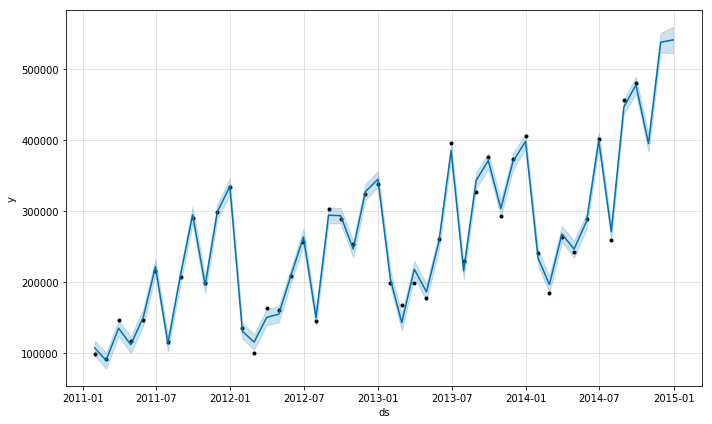

In [8]:
# carrega os dados e organiza as datas 
df = pd.read_csv('superstore_dataset2011-2015.csv', encoding= 'unicode_escape')
predict = df[['Order Date', 'Sales']]
predict[["Order Date"]] = predict[["Order Date"]].apply(lambda x: pd.to_datetime(x,errors = 'coerce', dayfirst=True))
predict = predict.sort_values('Order Date')

# prepara o conjunto de dados agrupando o somatório das vendas por mês
predict.columns = ['ds', 'y']
predict = predict.groupby('ds', as_index=False).sum()
predict = predict.set_index("ds").groupby(pd.Grouper(freq='M')).sum().reset_index()

# separa dois conjuntos de dados, um de teste(3 últimos meses) e um de treino (o restante dos meses anteriores)
train = predict.loc[predict.ds < "2014-10-31"]
test = predict.loc[predict.ds >= "2014-10-31"]

# cria o modelo
model = Prophet(changepoint_prior_scale=0.8, daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True) 
model.fit(train)
future = model.make_future_dataframe(periods =3 , freq = "m")
forecast = model.predict(future)

# plot dos dados reais e das previsões
model.plot(forecast);

# erro médio absoluto do modelo em %
MAPE_S = mean_absolute_percentage_error(y_true = test['y'], y_pred = forecast['yhat'].tail(3))
print('Erro médio absoluto %: ', round(MAPE_S, 2),'\n')

Valor previsto para o próximo mês: [345810.01]


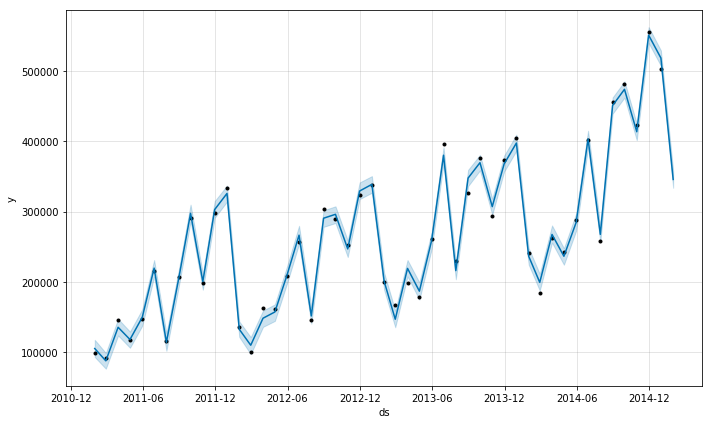

In [9]:
# model 
model = Prophet(changepoint_prior_scale=0.8, daily_seasonality=True, yearly_seasonality=True, weekly_seasonality=True)  
model.fit(predict)
future = model.make_future_dataframe(periods =1 , freq = "m")
forecast = model.predict(future)

predict = forecast[['ds', 'yhat_lower', 'yhat', 'yhat_upper']].merge(predict, on='ds', how='left')
predict = round(predict,2)

# plot
model.plot(forecast);

print('Valor previsto para o próximo mês:' , predict[predict.ds == '2015-01-31']['yhat'].values)

In [12]:
predict

,ds,yhat_lower,yhat,yhat_upper,y
0,2011-01-31,93151.37,105195.69,117602.60,98898.49
1,2011-02-28,76471.30,87668.73,98823.88,91152.16
2,2011-03-31,123788.30,135435.46,147388.17,145729.37
3,2011-04-30,106248.68,118024.33,129338.48,116915.76
4,2011-05-31,137707.53,149634.96,161082.84,146747.84
5,2011-06-30,207512.47,219593.36,231123.68,215207.38
6,2011-07-31,101956.96,114138.22,126618.73,115510.42
7,2011-08-31,192836.32,204475.94,216341.70,207581.49
8,2011-09-30,286269.75,297564.94,309982.77,290214.46
9,2011-10-31,188897.50,200524.27,211613.06,199071.26


# Exercício 3

In [13]:
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [14]:
df = pd.read_csv('superstore_dataset2011-2015.csv', encoding= 'unicode_escape')
df.head().T

,0,1,2,3,4
Row ID,42433,22253,48883,11731,22255
Order ID,AG-2011-2040,IN-2011-47883,HU-2011-1220,IT-2011-3647632,IN-2011-47883
Order Date,1/1/2011,1/1/2011,1/1/2011,1/1/2011,1/1/2011
Ship Date,6/1/2011,8/1/2011,5/1/2011,5/1/2011,8/1/2011
Ship Mode,Standard Class,Standard Class,Second Class,Second Class,Standard Class
Customer ID,TB-11280,JH-15985,AT-735,EM-14140,JH-15985
Customer Name,Toby Braunhardt,Joseph Holt,Annie Thurman,Eugene Moren,Joseph Holt
Segment,Consumer,Consumer,Consumer,Home Office,Consumer
City,Constantine,Wagga Wagga,Budapest,Stockholm,Wagga Wagga
State,Constantine,New South Wales,Budapest,Stockholm,New South Wales


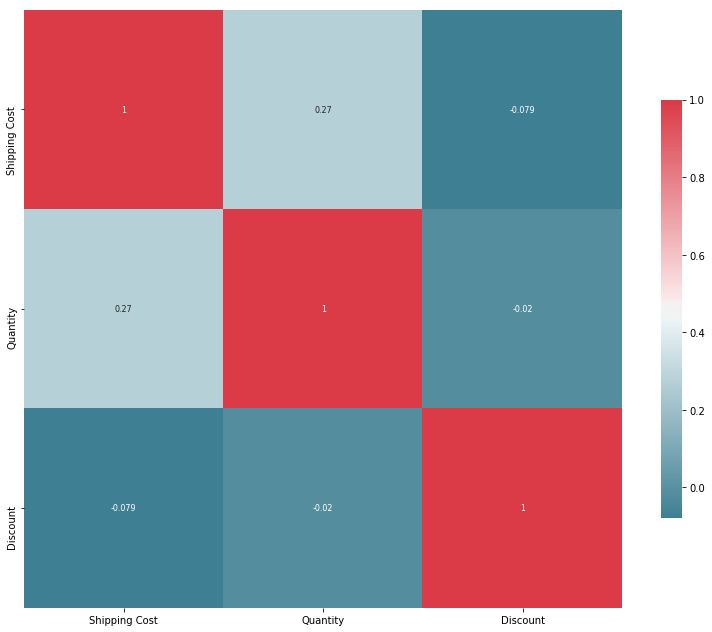

In [15]:
# Matriz de correlação
corr = df[['Shipping Cost', 'Quantity', 'Discount']].corr()
_ , ax = plt.subplots( figsize =( 14 , 11 ) )
cmap = sns.diverging_palette( 220 , 10 , as_cmap = True )
_ = sns.heatmap(corr, cmap = cmap, square=True, cbar_kws={ 'shrink' : .7 }, ax=ax, annot = True, annot_kws = {'fontsize' : 8 })

In [16]:
# agrupa por categoria e por valor de desconto pra ver se a correlação com a quantidade muda em alguma categoria 
Discount = df[['Category', 'Discount', 'Quantity']].groupby(['Category', 'Discount'], as_index=False).sum()

# agrupa por categoria e por valor de frete pra ver se a correlação com a quantidade muda em alguma categoria 
Shipping_Cost = df[['Category', 'Shipping Cost', 'Quantity']].groupby(['Category', 'Shipping Cost'], as_index=False).sum()

In [17]:
Shipping_Cost[['Shipping Cost', 'Quantity']].corr(method='pearson')

,Shipping Cost,Quantity
Shipping Cost,1.000000,-0.179391
Quantity,-0.179391,1.000000


In [18]:
Discount[['Discount', 'Quantity']].corr(method='pearson')

,Discount,Quantity
Discount,1.000000,-0.354371
Quantity,-0.354371,1.000000


##### Extra:

In [19]:
# Agrupa por preço do produto e categoria
df['price'] = df.Sales / df.Quantity
price = df[['Product Name', 'price', 'Quantity']].groupby(['Product Name', 'price'], as_index = False).sum()

In [20]:
price.head()

,Product Name,price,Quantity
0,"""While you Were Out"" Message Book, One Form pe...",2.968,6
1,"""While you Were Out"" Message Book, One Form pe...",3.710,2
2,"#10 Gummed Flap White Envelopes, 100/Box",3.304,2
3,"#10 Gummed Flap White Envelopes, 100/Box",3.304,3
4,"#10 Gummed Flap White Envelopes, 100/Box",4.130,6
